# Individual_household_electric_power_consumption

## Dataset Information
Hebrail,Georges and Berard,Alice. (2012). Individual Household Electric Power Consumption. UCI Machine Learning Repository. https://doi.org/10.24432/C58K54.

 Measurements of electric power consumption in one household with a **one-minute sampling rate** over a period of almost 4 years. This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

## Variable Information
1. **date**: Date in format dd/mm/yyyy
2. **time**: time in format hh:mm:ss
3. **global_active_power**: household global minute-averaged active power (in kilowatt)
4. **global_reactive_power**: household global minute-averaged reactive power (in kilowatt)
5. **voltage**: minute-averaged voltage (in volt)
6. **global_intensity**: household global minute-averaged current intensity (in ampere)
7. **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

## *Imported Libraries*

In [1]:
# Data handling
import pandas as pd              
import numpy as np               

# Data visualization
import matplotlib.pyplot as plt   

import matplotlib.dates as mdates  
import seaborn as sns              

# Statistical modeling/machine learning
from sklearn.ensemble import RandomForestRegressor

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p pandas,numpy,matplotlib,seaborn,sklearn

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.22.1

pandas    : 2.2.1
numpy     : 1.26.4
matplotlib: 3.8.3
seaborn   : 0.13.2
sklearn   : 1.4.2



## 1. Acuquire and Prepare Data

### Import Data in Python

In [ ]:
"""
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
"""

### Accessing Locally Stored Data File

Retrive data from https://doi.org/10.24432/C58K54

In [4]:
file_path = 'household_power_consumption.txt'
X = pd.read_csv(file_path, delimiter=';') 

C:\Users\matun\AppData\Local\Temp\ipykernel_12680\3958219844.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv(file_path, delimiter=';')


### Initial Data Review to Verify Successful Acquisition

In [5]:
X.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## 2. Data Cleaning and Preprocessing

### 2.1 Conversion of Data Types

In [7]:
X['Date'] = pd.to_datetime(X['Date'], format='%d/%m/%Y')

columns_to_float = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
X[columns_to_float] = X[columns_to_float].apply(lambda col: pd.to_numeric(col, errors='coerce'))

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 142.5+ MB


### 2.2 Checking for Missing Values

In [9]:
X.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
total_entries = 2075259
null_entries = 25979
print(f'Percentage of missing data {null_entries/total_entries*100:.2f}%')

Percentage of missing data 1.25%


### 2.3 Analysis of Missing Data

In [11]:
# Identifying rows with missing values
rows_with_nulls = X[X.isnull().any(axis=1)]

# Grouping missing values by date and counting them
nulls_by_date = rows_with_nulls.groupby('Date').size().reset_index(name='Count')

# Printing the result
nulls_by_date

,Date,Count
0,2006-12-21,2
1,2006-12-30,2
2,2007-01-14,1
3,2007-01-28,1
4,2007-02-22,2
...,...,...
77,2010-09-25,1204
78,2010-09-26,1440
79,2010-09-27,1440
80,2010-09-28,1153


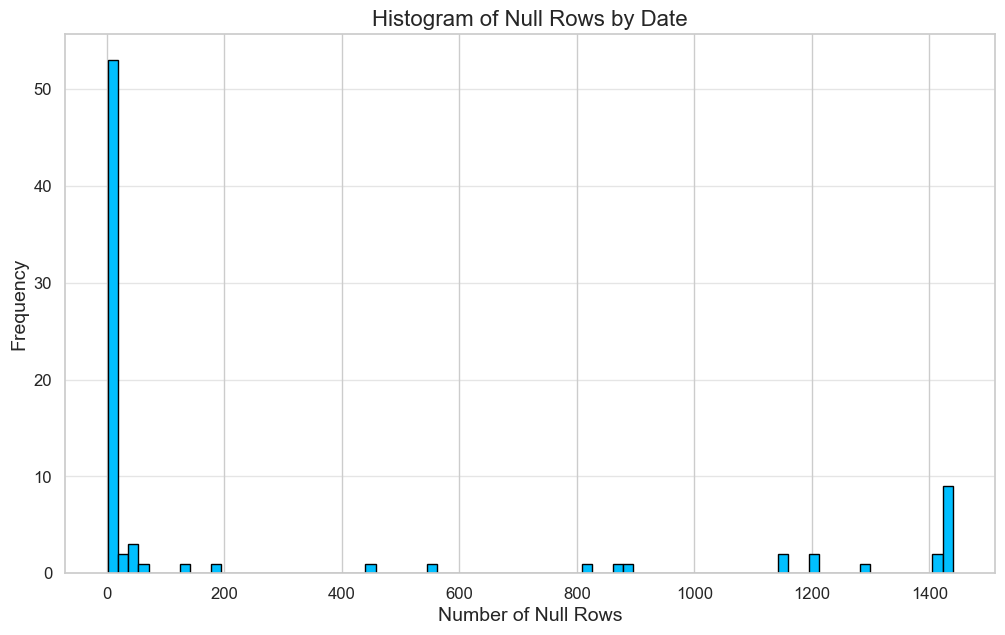

In [12]:
sns.set(style="whitegrid")

nulls_by_date["Date"] = pd.to_datetime(nulls_by_date["Date"])


plt.figure(figsize=(12, 7))
plt.hist(nulls_by_date["Count"], bins=len(nulls_by_date), color='deepskyblue', edgecolor='black')
plt.title("Histogram of Null Rows by Date", fontsize=16)
plt.xlabel("Number of Null Rows", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
daily_entries = 1440  # Total daily entries (one entry per minute over 24 hours)
five_pct_entries = 0.05 * daily_entries
fifty_pct_entries = 0.5 * daily_entries

# Counting days with less than 5% null entries
less_than_five = (nulls_by_date['Count'] <= five_pct_entries).sum()
print('Less than 5%: ', less_than_five)

# Counting days with 5% to 50% null entries
five_to_fifty = ((nulls_by_date['Count'] > five_pct_entries) & (nulls_by_date['Count'] <= fifty_pct_entries)).sum()
print('5% to 50%: ', five_to_fifty)

# Counting days with more than 50% null entries
more_than_fifty = (nulls_by_date['Count'] > fifty_pct_entries).sum()
print('More than 50%: ', more_than_fifty)

Less than 5%:  59
5% to 50%:  4
More than 50%:  19


In [14]:
full_day_null = nulls_by_date[nulls_by_date['Count'] == 1440]
full_day_null

,Date,Count
7,2007-04-29,1440
48,2009-06-14,1440
59,2010-01-13,1440
72,2010-08-18,1440
73,2010-08-19,1440
74,2010-08-20,1440
75,2010-08-21,1440
78,2010-09-26,1440
79,2010-09-27,1440


####  *Distribution of Missing Data*:

- **59 days** have *5%* missing records for the entire day.
- **4 days** have *more than 5% but less than 50%* missing records.
- **10 days** are missing *more than 50%* of data but not for the entire day.
- **9 days** are missing all records for the *entire day*.

Furthermore, the distribution of days with completely missing records is as follows:

- 1 day in March 2007
- 1 day in June 2009
- 7 days in 2010:
    - 1 day in January
    - 4 consecutive days in August (18-21)
    - 2 days in September (26 and 27)

### 2.4 Cleaning for Days with Less Than 5% Missing Data

For days with less than 5% missing data, linear interpolation is an excellent method for estimating the missing values. This method presupposes that changes between available data points are linear, making it suitable for accurately filling in short gaps. Given the brief intervals of missing data, linear interpolation can provide estimates close to the actual values, thereby minimizing data distortion.

In [15]:
rows = nulls_by_date[nulls_by_date['Count'] <= five_pct_entries]

X.set_index('Date', inplace=True)

for date in rows['Date']:
    date_mask = X.index.date == date.date()
    numeric_columns = X.select_dtypes(include='float64').columns
    X.loc[date_mask, numeric_columns] = X.loc[date_mask, numeric_columns].interpolate(method='nearest')

In [16]:
print(X.isnull().sum())

Time                         0
Global_active_power      25668
Global_reactive_power    25668
Voltage                  25668
Global_intensity         25668
Sub_metering_1           25668
Sub_metering_2           25668
Sub_metering_3           25668
dtype: int64


### 2.5 Cleaning for Days with 5% to 99% null entries

In [25]:
pct_entries =0.99 * daily_entries
rows = nulls_by_date[nulls_by_date['Count'] <= pct_entries]

for date in rows['Date']:
    date_mask = X.index.date == date.date()
    numeric_columns = X.select_dtypes(include='float64').columns
    X.loc[date_mask, numeric_columns] = X.loc[date_mask, numeric_columns].interpolate(method='linear')

In [30]:
print(X.isnull().sum())

Time                         0
Global_active_power      18681
Global_reactive_power    18681
Voltage                  18681
Global_intensity         18681
Sub_metering_1           18681
Sub_metering_2           18681
Sub_metering_3           18681
dtype: int64


### 2.6 Grouping Data by Day

In [32]:
columns_to_keep = X.columns[-7:].tolist()
Xa = X[columns_to_keep]
daily_sum = Xa.resample('D').sum()
is_all_null = Xa.resample('D').apply(lambda x: x.isnull().all())
daily_sum[is_all_null] = None

In [33]:
daily_sum.isnull().sum()

Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

#### 2.6.1 Cleaning Null data

In [34]:
daily_sum = daily_sum.interpolate(method='linear')
daily_sum.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## 3. Selection of Independent Variables

Identifying the Optimal Independent Variable for Linear Regression with 'Global_active_power' as the Dependent Variable"

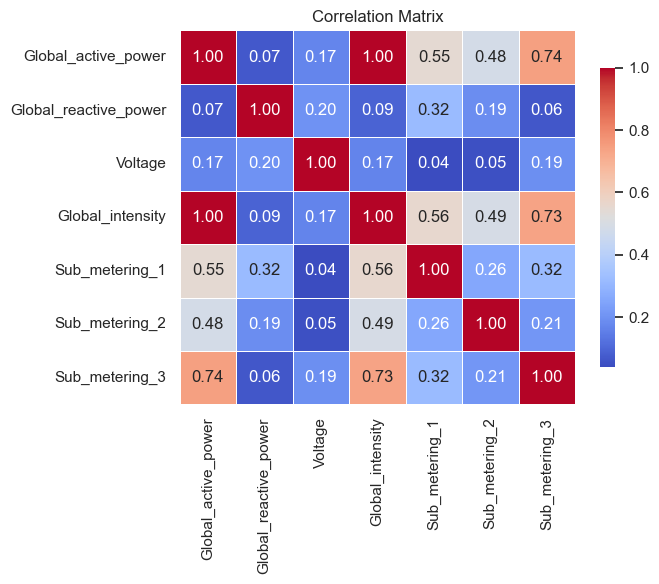

In [35]:
# Calculate the correlation matrix
correlation_matrix = daily_sum.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(7, 6)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix') 
plt.tight_layout()  
plt.show()

The variable that exhibits the highest correlation with 'Global_active_power' is 'Global_intensity', followed by 'Sub_metering_3', 'Sub_metering_1', and 'Sub_metering_2'. However, the perfect correlation (1.00) of 'Global_intensity' may suggest redundancy or a direct measurement relationship rather than an independent effect. Therefore, it may not be considered a reliable independent variable for modeling purposes. Given this, 'Sub_metering_3' is identified as the variable with the next highest correlation and is selected as the primary independent variable for analysis.

## 4. Random Forest Regressor Models

This section details the development of Random Forest Regressor models trained on a quarterly data subset, as an example from January to March 2007. The focus is to capture seasonal patterns within the first quarter of the year that may influence the model's predictive accuracy.

In [36]:
def train_linear_models(independent_vars, estimators, data=daily_sum, dependent_var='Global_active_power'):
    start_date = pd.to_datetime('2007-01-01')
    end_date = pd.to_datetime('2010-12-31')
    models = []

    while start_date + pd.DateOffset(months=3) <= end_date:
        train_end_date = start_date + pd.DateOffset(months=3) - pd.DateOffset(days=1)   
        three_months_data = data[start_date:train_end_date]
        
        X = three_months_data[independent_vars].values
        y = three_months_data[dependent_var].values
        
        model = RandomForestRegressor(n_estimators = estimators)
        model.fit(X, y)
        models.append(model)
        
        start_date += pd.DateOffset(months=1)

    return models

### 4.1 One independent varible

'Sub_metering_3' is used as the independent variable to predict the dependent variable 'Global_active_power'

In [37]:
models_1 = train_linear_models(['Sub_metering_3'], 100)

### 4.2 Two and Three Independent Varibles

'Sub_metering_3' and 'Sub_metering_1' are used as the independent variables

In [38]:
models_2 = train_linear_models(['Sub_metering_3', 'Sub_metering_1'], 100)

'Sub_metering_3', 'Sub_metering_1', and 'Sub_metering_2' are used as the independent variables

In [39]:
models_3 = train_linear_models(['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2'], 100)

## 6. Predictions

In [41]:
def predict_with_models(models, independent_variables):
    prediction_start_date = pd.to_datetime('2007-04-01')
    prediction_end_date = pd.to_datetime('2010-12-31')

    all_rows = []
    current_date = prediction_start_date
    current_month = None
    model = None
    i = 0

    while current_date <= prediction_end_date:
        if current_date in daily_sum.index:
            if current_date.month != current_month:
                current_month = current_date.month
                model = models[i]
                i += 1

            x_values = daily_sum.loc[current_date, independent_variables]
            real_power = daily_sum.at[current_date, 'Global_active_power']
            y_pred = model.predict([x_values.values])

            temp_df = pd.DataFrame({
                'Date': [current_date],
                'Pred_GAP': [y_pred.item()],
                'Real_GAP': [real_power]
            })

            all_rows.append(temp_df) 

        current_date += pd.DateOffset(days=1)

    results = pd.concat(all_rows) 
    return results

In [42]:
results_mod1 = predict_with_models(models_1, ['Sub_metering_3'])
results_mod1.head()

,Date,Pred_GAP,Real_GAP
0,2007-04-01,3706.87766,2785.952
0,2007-04-02,2897.62358,1960.778
0,2007-04-03,2390.09728,1642.820
0,2007-04-04,3227.00108,2051.868
0,2007-04-05,1529.51946,1844.078


In [43]:
results_mod2 = predict_with_models(models_2, ['Sub_metering_3', 'Sub_metering_1'])
print(results_mod2.head())

        Date    Pred_GAP  Real_GAP
0 2007-04-01  3825.32216  2785.952
0 2007-04-02  2744.93628  1960.778
0 2007-04-03  1896.48006  1642.820
0 2007-04-04  3186.44678  2051.868
0 2007-04-05  1597.25760  1844.078


In [44]:
results_mod3 = predict_with_models(models_3, ['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2'])
print(results_mod3.head())

        Date    Pred_GAP  Real_GAP
0 2007-04-01  3693.72370  2785.952
0 2007-04-02  2234.83158  1960.778
0 2007-04-03  1930.24000  1642.820
0 2007-04-04  2378.07616  2051.868
0 2007-04-05  2288.09354  1844.078


In [45]:
def plot_monthly_comparison(results):
    results['month_year'] = results['Date'].dt.to_period('M')

    monthly_data = results.groupby('month_year').agg({
        'Pred_GAP': 'sum',
        'Real_GAP': 'sum'
    }).reset_index()

    monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

    # Crear y configurar el gráfico
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_data['month_year'], monthly_data['Pred_GAP'], label='Predicted Global Active Power (Pred_GAP)', marker='o')
    plt.plot(monthly_data['month_year'], monthly_data['Real_GAP'], label='Real Global Active Power (Real_GAP)', marker='o')
    plt.title('Monthly Comparison of Predicted and Real Global Active Power')
    plt.xlabel('Month')
    plt.ylabel('Sum of Global Active Power (kWh)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

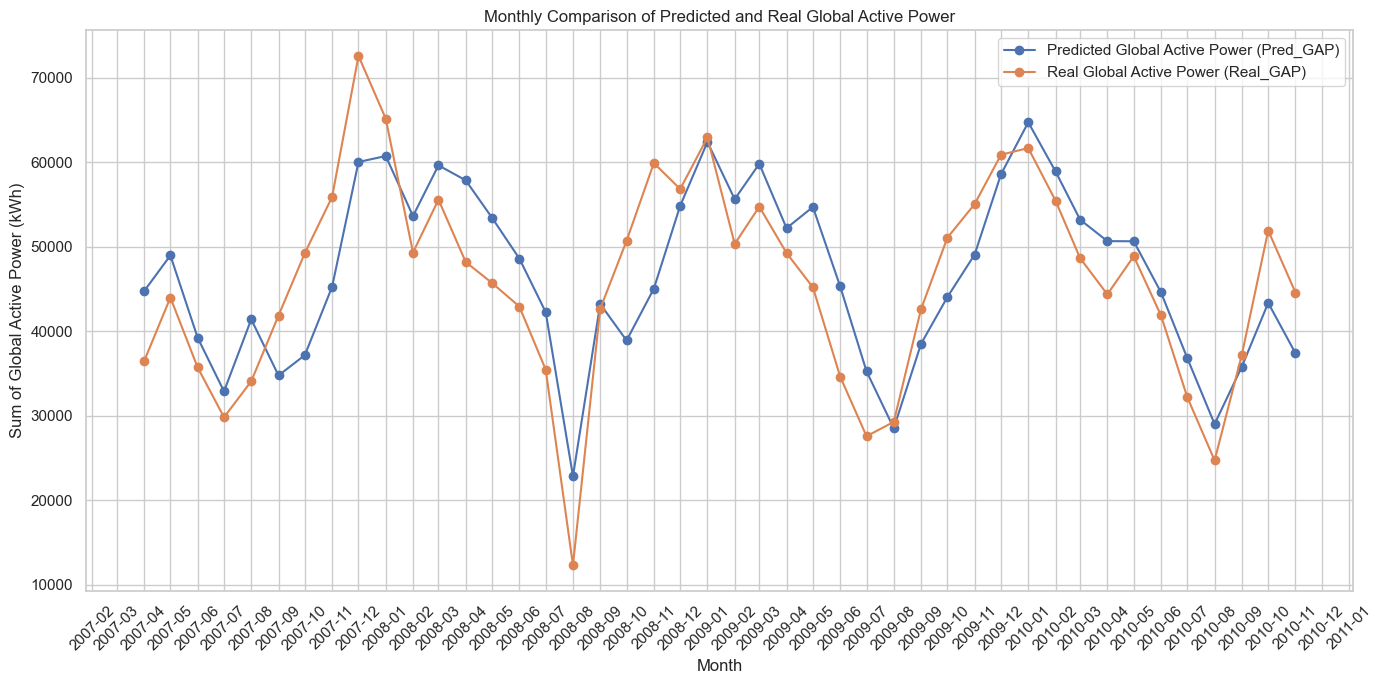

In [46]:
plot_monthly_comparison(results_mod1)

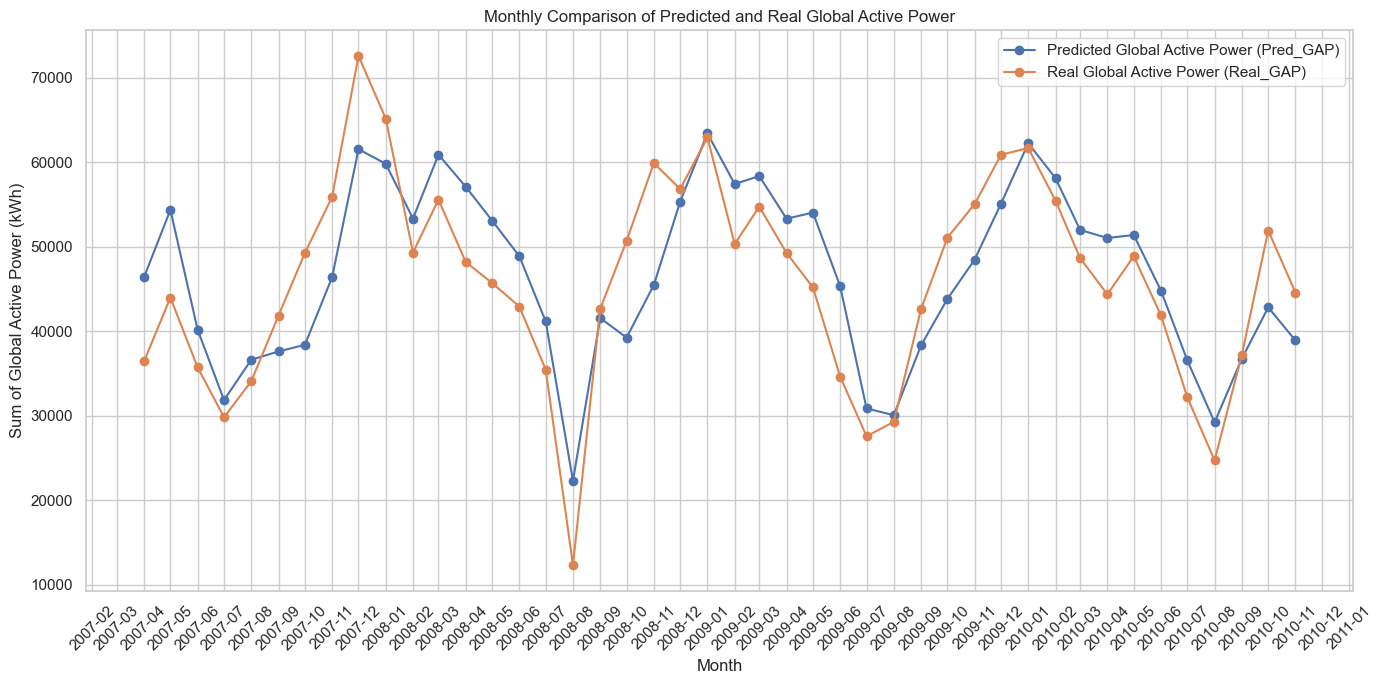

In [47]:
plot_monthly_comparison(results_mod2)

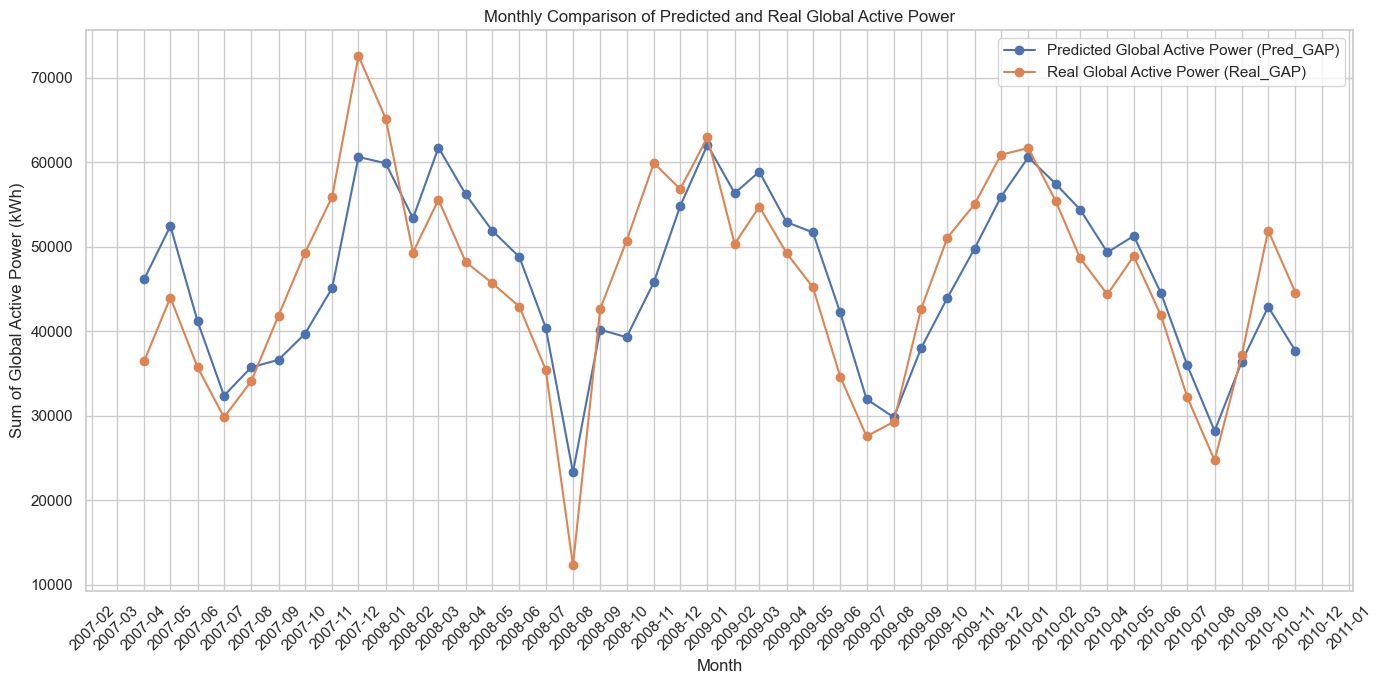

In [48]:
plot_monthly_comparison(results_mod3)

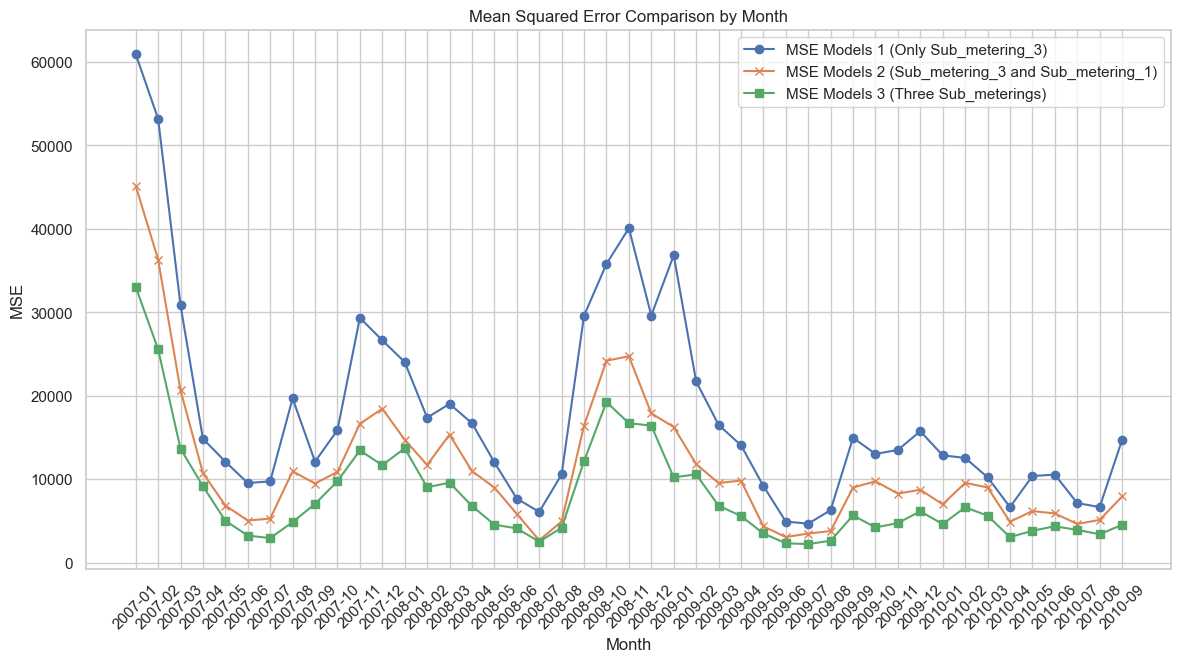

In [49]:
errors = pd.DataFrame()
start_date = pd.to_datetime('2007-01-01')
end_date = pd.to_datetime('2010-12-31')
current_date = start_date
i = 0

while current_date + pd.DateOffset(months=2) <= end_date and i < len(models_1) and i < len(models_2) and i < len(models_3):
    two_months_data = daily_sum[current_date:current_date + pd.DateOffset(months=2)]

    X1 = two_months_data['Sub_metering_3'].values.reshape(-1, 1)
    X2 = two_months_data[['Sub_metering_3', 'Sub_metering_1']].values
    X3 = two_months_data[['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2']].values
    y_true = two_months_data['Global_active_power'].values
    
    y_pred1 = models_1[i].predict(X1)
    y_pred2 = models_2[i].predict(X2)
    y_pred3 = models_3[i].predict(X3)

    mse1 = np.mean((y_pred1 - y_true) ** 2)
    mse2 = np.mean((y_pred2 - y_true) ** 2)
    mse3 = np.mean((y_pred3 - y_true) ** 2)

    temp_df = pd.DataFrame({
        'month_year': [current_date.strftime('%Y-%m')],
        'MSE_models': [mse1],
        'MSE_models2': [mse2],
        'MSE_models3': [mse3]
    })
    errors = pd.concat([errors, temp_df], ignore_index=True)
  
    current_date += pd.DateOffset(months=1)
    i += 1

plt.figure(figsize=(14, 7))
plt.plot(errors['month_year'], errors['MSE_models'], label='MSE Models 1 (Only Sub_metering_3)', marker='o')
plt.plot(errors['month_year'], errors['MSE_models2'], label='MSE Models 2 (Sub_metering_3 and Sub_metering_1)', marker='x')
plt.plot(errors['month_year'], errors['MSE_models3'], label='MSE Models 3 (Three Sub_meterings)', marker='s')
plt.title('Mean Squared Error Comparison by Month')
plt.xlabel('Month')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [83]:
from scipy.stats import wilcoxon

wilcoxon(results_mod3['Real_GAP'], results_mod3['Pred_GAP'])

WilcoxonResult(statistic=391169.0, pvalue=8.601252447010874e-05)

# 7. Paired Z-Test

- **Null Hypothesis (H0)**: There is no significant difference between the actual values and the predicted values.
- **Alternative Hypothesis (H1)**: There is a significant difference between the actual values and the predicted values.


In [51]:
import scipy.stats as stats

def monthly_paired_z_test(df, alpha=0.05):
    
    results = []

    for month_year, group in df.groupby('month_year'):
        actual_values = group['Real_GAP']
        predicted_values = group['Pred_GAP']

        differences = actual_values - predicted_values

        mean_differences = np.mean(differences)

        std_differences = np.std(differences, ddof=1)

        n = len(differences)

        z_score = mean_differences / (std_differences / np.sqrt(n))

        z_critical = stats.norm.ppf(1- alpha / 2)

        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

        if abs(z_score) > z_critical:
            interpretation = "Reject the null hypothesis"
            interpretation_v = 1
        else:
            interpretation = "Fail to reject the null hypothesis"
            interpretation_v = 0

        results.append({
            'month_year': month_year,
            'z_score': z_score,
            'z_critical': z_critical,
            'p_value': p_value,
            'interpretation': interpretation,
            'interpretation_value': interpretation_v
        })

    results_df = pd.DataFrame(results)

    return results_df

In [52]:
ztest_mod1 = monthly_paired_z_test(results_mod1)
ztest_mod2 = monthly_paired_z_test(results_mod2)
ztest_mod3 = monthly_paired_z_test(results_mod3)

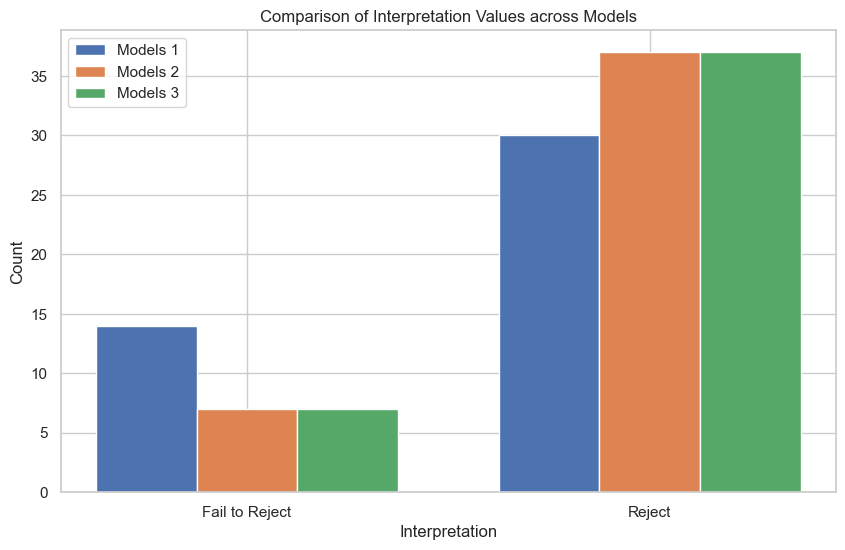

In [55]:
count_mod1 = ztest_mod1['interpretation_value'].value_counts().sort_index()
count_mod2 = ztest_mod2['interpretation_value'].value_counts().sort_index()
count_mod3 = ztest_mod3['interpretation_value'].value_counts().sort_index()

count_df = pd.DataFrame({
    'Model 1': count_mod1,
    'Model 2': count_mod2,
    'Model 3': count_mod3
}).fillna(0)  

count_df.index = ['Fail to Reject', 'Reject']

bar_width = 0.25
bar_positions = np.arange(len(count_df.index))

plt.figure(figsize=(10, 6))
plt.bar(bar_positions - bar_width, count_df['Model 1'], width=bar_width, label='Models 1')
plt.bar(bar_positions, count_df['Model 2'], width=bar_width, label='Models 2')
plt.bar(bar_positions + bar_width, count_df['Model 3'], width=bar_width, label='Models 3')
plt.xlabel('Interpretation')
plt.ylabel('Count')
plt.title('Comparison of Interpretation Values across Models')
plt.xticks(bar_positions, count_df.index)
plt.legend()
plt.show()

- **Null Hypothesis (H0)**: There is no significant difference between the actual values and the predicted values.
- **Alternative Hypothesis (H1)**: There is a significant difference between the actual values and the predicted values.

# 8. Evaluation Using Three Independent Variables and diferent n_estimators

In [58]:
results_mod3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1336 entries, 0 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1336 non-null   datetime64[ns]
 1   Pred_GAP    1336 non-null   float64       
 2   Real_GAP    1336 non-null   float64       
 3   month_year  1336 non-null   period[M]     
dtypes: datetime64[ns](1), float64(2), period[M](1)
memory usage: 52.2 KB


In [63]:
estimators_test = [100, 200, 300, 400, 500, 750, 1000, 1250]

from sklearn.metrics import mean_squared_error

results_test = []

for estimatorTest in estimators_test:
    models_3_test = train_linear_models(['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2'], estimatorTest)
    results_mod3_test = predict_with_models(models_3_test, ['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2'])
    
    daily_mse = mean_squared_error(results_mod3_test['Real_GAP'], results_mod3_test['Pred_GAP'])
    daily_errors = results_mod3_test['Real_GAP'] - results_mod3_test['Pred_GAP']
    daily_std_dev = np.std(daily_errors)

    monthly_mse = []
    monthly_std_dev = []
    results_mod3_test['YearMonth'] = results_mod3_test['Date'].dt.to_period('M')
    grouped = results_mod3_test.groupby('YearMonth')

    for name, group in grouped:
        errors = group['Real_GAP'] - group['Pred_GAP']
        mse = mean_squared_error(group['Real_GAP'], group['Pred_GAP'])
        std_dev = np.std(errors)
        monthly_mse.append((name, mse))
        monthly_std_dev.append((name, std_dev))

    mse_df = pd.DataFrame(monthly_mse, columns=['YearMonth', 'MSE'])
    std_dev_df = pd.DataFrame(monthly_std_dev, columns=['YearMonth', 'Standard_Deviation'])

    result_test_dic = {
        'numEstimators': estimatorTest,
        'resultsPrediction': results_mod3_test,
        'MSE_pred_daily': daily_mse,
        'daily_std_dev': daily_std_dev,
        'monthly_mse_df': mse_df,
        'monthly_std_dev_df': std_dev_df
    }

    results_test.append(result_test_dic)

WilcoxonResult(statistic=397488.0, pvalue=0.0005033060687917128)
MSE_daily: 95049.2700107028, std_daily: 308.11707890433706
MSE_Montly_mean: 95008.39841258978
std_Montly_mean: 210.87698994165132


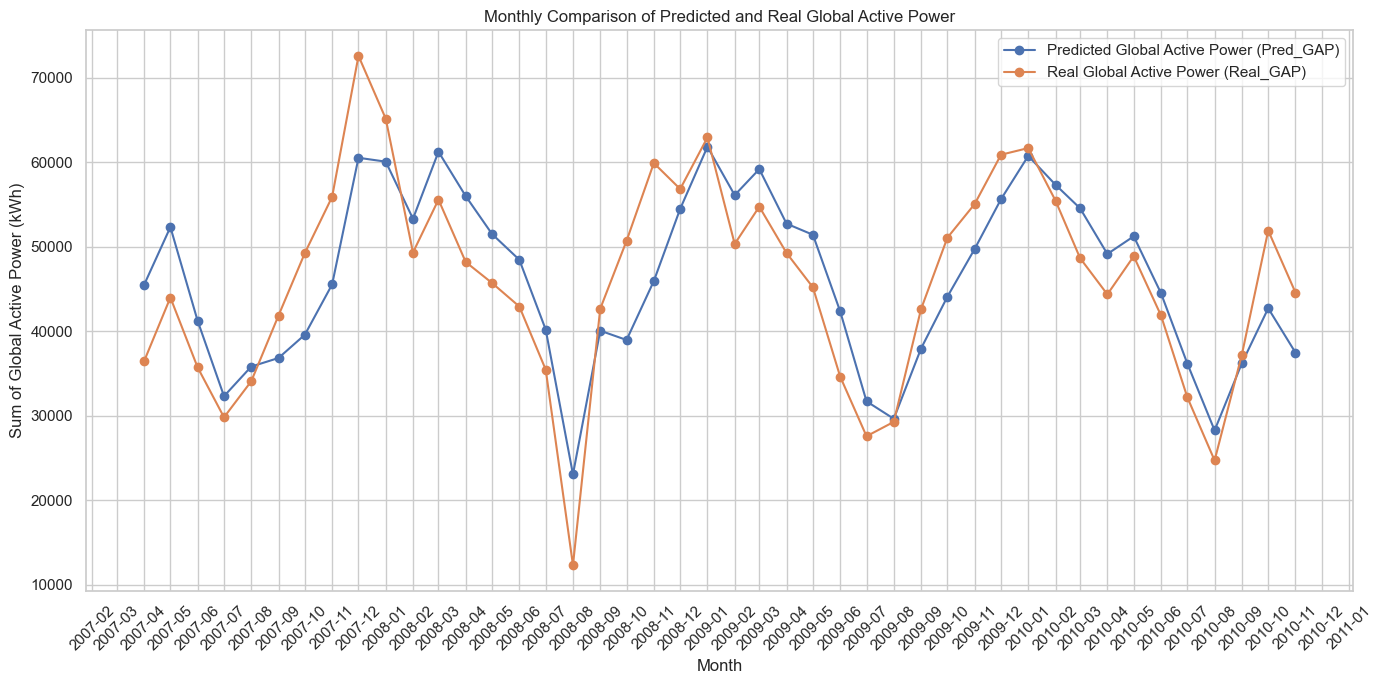

In [93]:
result = results_test[0]
mse_df_result = result['monthly_mse_df']
std_dev_rsult = result['monthly_std_dev_df']
pred_result = result['resultsPrediction']
print(wilcoxon(pred_result['Real_GAP'], pred_result['Pred_GAP']))
print(f"MSE_daily: {result['MSE_pred_daily']}, std_daily: {result['daily_std_dev']}")
print(f"MSE_Montly_mean: {np.mean(mse_df_result['MSE'])}")
print(f"std_Montly_mean: {np.mean(std_dev_rsult['Standard_Deviation'])}")
plot_monthly_comparison(result['resultsPrediction'])